In [ ]:
MAX_NUM_THREADS = 4

import ctypes
mkl_rt = ctypes.CDLL('libmkl_rt.so')
#print(mkl_rt.mkl_get_max_threads())
mkl_get_max_threads = mkl_rt.mkl_get_max_threads
def mkl_set_num_threads(cores):
    mkl_rt.mkl_set_num_threads(ctypes.byref(ctypes.c_int(cores)))

mkl_set_num_threads(MAX_NUM_THREADS)
print(f'Number of threads was limited to {mkl_get_max_threads()}.')

In [2]:
import os
import sys
sys.path.append('../src/')

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from tools import numpy_tools
import loaders.eth80 as eth80
import loaders.smni_eeg as smni_eeg

## ETH-80

In [12]:
data_dirname = '../data/eth80/'

In [8]:
# download
eth80.downloadETH80(save_data_dirname=data_dirname)

In [14]:
# check downloaded files
data_dirname = os.path.join(data_dirname, 'eth80-cropped-close128')

image_shape = 32
Nclasses, Nobjects = 8, 10
Npixels = int(round(image_shape**2))

data, labels, classes = eth80.eth80_dataset(data_dirname, image_shape)
classes_reverse_dict = dict((y, x) for x, y in classes.items())
Nsamples, Nangles, _, _, Ncolors = data.shape
data = numpy_tools.reshape_np(data, [Nangles, -1, Ncolors], order='F', use_batch=True)
permutation = [0, 2, 1, 3]
data = np.transpose(data, permutation)

n = [Npixels, Nangles, Ncolors]

In [15]:
print(classes)

{'apple': 0, 'car': 1, 'cow': 2, 'cup': 3, 'dog': 4, 'horse': 5, 'pear': 6, 'tomato': 7}


apple


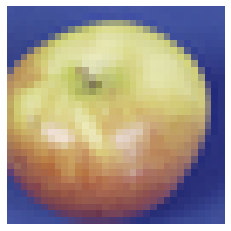

In [18]:
i_class = 0
i_obj = 4
i_angle = 6

ind = np.ravel_multi_index((i_class, i_obj), (Nclasses, Nobjects), order='C')

plt.imshow(
    numpy_tools.reshape_np(
        data[ind, :, i_angle, :],
        [image_shape, image_shape, Ncolors],
        order='F',
        use_batch=False
    )
)
plt.axis('off');
print(classes_reverse_dict[i_class])

## SMNI EEG (alcoholism / control)

In [3]:
data_dirname = '../data/eeg_smni/'

In [4]:
smni_eeg.downloadSMNI(data_dirname)

In [5]:
save_filename = 'smni_eeg.npz'
save_path = os.path.join(data_dirname, save_filename)
persons_data = smni_eeg.loadDirectory(data_dirname, return_df=True, save_path=save_path)

 co3c0000402: 100.000%

In [6]:
condition_keys = list(
    filter(
        lambda x: x != smni_eeg._mistake_key, smni_eeg._conditions.keys()
    )
)
condition_keys.sort()

data, labels = [], []
for i in range(len(persons_data)):
    current_person_conditions = np.array(persons_data[i]['conditions'])
    current_person_data = []
    for j in range(len(condition_keys)):
        condition_code = smni_eeg._conditions[condition_keys[j]]
        ind = np.where(current_person_conditions == condition_code)[0]
        current_person_data.append(
            np.mean(persons_data[i]['data'][ind, :, :], axis=0)
        )
    data.append(np.stack(current_person_data, axis=-1))
    labels.append(persons_data[i]['label'])
data = np.array(data)
labels = np.array(labels)

In [7]:
save_filename = 'smni_eeg_processed.npz'
save_path = os.path.join(data_dirname, save_filename)
np.savez_compressed(save_path, data=data, labels=labels)

===== S1 obj ==


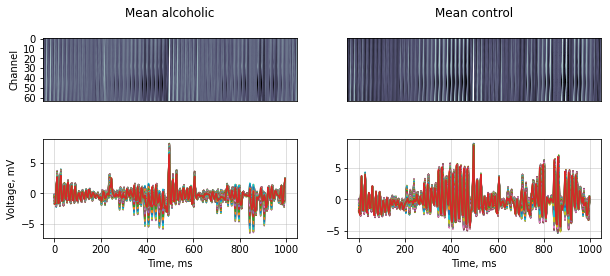

===== S2 match ==


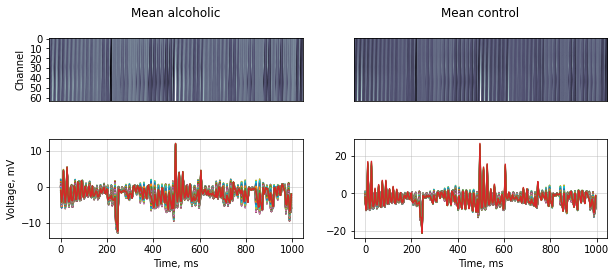

===== S2 nomatch ==


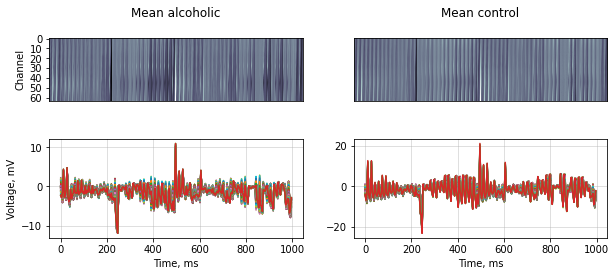

In [8]:
processed_filename = 'smni_eeg_processed.npz'
df = np.load(os.path.join(data_dirname, processed_filename))
data, labels = df['data'], df['labels']

Nsubjects, Nchannels, Ntime, Nconditions = data.shape

ind_alcohol = np.where(labels == smni_eeg._classes['a'])[0]
ind_control = np.where(labels == smni_eeg._classes['c'])[0]

mean_alcohol_person = np.mean(data[ind_alcohol], axis=0)
mean_control_person = np.mean(data[ind_control], axis=0)

sample_frequency = 256 # Hz
timepoints = 1000.*np.arange(Ntime) / sample_frequency # ms


for k in range(len(condition_keys)):
    print(f'===== {condition_keys[k]} ==')
    fig, ax = plt.subplots(2, 2, figsize=(10, 4))

    ax[0, 0].matshow(mean_alcohol_person[:, :, k], cmap='bone')
    ax[0, 1].matshow(mean_control_person[:, :, k], cmap='bone')
    ax[0, 0].set_ylabel('Channel')
    ax[0, 0].set_title('Mean alcoholic\n')
    ax[0, 1].set_title('Mean control\n')
    yaxis = ax[0, 1].axes.get_yaxis()
    yaxis.set_visible(False)
    xaxis = ax[0, 0].axes.get_xaxis()
    xaxis.set_visible(False)
    xaxis = ax[0, 1].axes.get_xaxis()
    xaxis.set_visible(False)

    ax[1, 0].plot(timepoints, mean_alcohol_person[:, :, k].T)
    ax[1, 1].plot(timepoints, mean_control_person[:, :, k].T)
    ax[1, 0].set_xlabel('Time, ms')
    ax[1, 1].set_xlabel('Time, ms')
    ax[1, 0].set_ylabel('Voltage, mV')
    ax[1, 0].grid(alpha=0.5)
    ax[1, 1].grid(alpha=0.5)
    plt.savefig(f'eeg_smni_{k}.pdf')
    plt.show()